# Basic Imports

In [1]:
# Basic Imports
import datetime
import math
import os
import sys
import random
import numpy as np
from multi_modal_constants import *
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# PyTorch related imports....
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import torchvision.transforms.functional as TF
import torchvision
from torchvision import datasets, models, transforms
import time
from tempfile import TemporaryDirectory
import models_vit
import models_mae
from rFmodel import *
from data_loader import *
import pandas as pd
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget, BinaryClassifierOutputTarget

device = "cuda" if torch.cuda.is_available() else "cpu"

/tscc/nfs/home/vejoshi/anaconda3/envs/P_torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version : 2.3.0+cu121 | Device type : cuda


# Common Pre-processing op

In [4]:
pre_proc_func = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                         std=[0.229, 0.224, 0.225])])

# Single Modality Fundus_model

In [3]:
single_mod_fundus = torch.load("/tscc/nfs/home/vejoshi/oct_fundus_project/ret_found_exp/RETFound_MAE/experiments/best_fundus/retFoundretFound_shape_224_dp_0.1_lr_0.0005_run_0.pt",
                                map_location = device)
fundus_single_modal = build_model()
fundus_single_modal.load_state_dict(single_mod_fundus, strict=False)
fundus_single_modal = fundus_single_modal.to("cuda")
fundus_single_modal.eval()
print("Loaded single modality fundus best model.")

Loaded single modality fundus best model.


# Extracting TP,TN,FP, FN images.
- 0 == Glaucoma
- 1 == Healthy

In [56]:
tp_img_path = "/tscc/nfs/home/vejoshi/oct_fundus_project/oct_fundus_dataset/fundus_images/SD2589_OD_075683_4.tif"
fp_img_path = "/tscc/nfs/home/vejoshi/oct_fundus_project/oct_fundus_dataset/fundus_images/NY7680_OD_074157_1.tif"
tn_img_path = "/tscc/nfs/home/vejoshi/oct_fundus_project/oct_fundus_dataset/fundus_images/NY7617_OS_076158_2.tif"
fn_img_path = "/tscc/nfs/home/vejoshi/oct_fundus_project/oct_fundus_dataset/fundus_images/AL1195_OD_074100_2.tif"

tp_img = PIL.Image.open(tp_img_path).convert('RGB').resize((224,224))
fp_img = PIL.Image.open(fp_img_path).convert('RGB').resize((224,224))
tn_img = PIL.Image.open(tn_img_path).convert('RGB').resize((224,224))
fn_img = PIL.Image.open(fn_img_path).convert('RGB').resize((224,224))

proc_tp_img = pre_proc_func(tp_img)
proc_fp_img = pre_proc_func(fp_img)
proc_tn_img = pre_proc_func(tn_img)
proc_fn_img = pre_proc_func(fn_img)

# Setting up gradCam ++

In [57]:
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1 :  , :].reshape(tensor.size(0),
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result
    
fundus_single_cam = GradCAMPlusPlus(model = fundus_single_modal, 
                                    target_layers=[fundus_single_modal.model.blocks[23].norm1], 
                                    reshape_transform = reshape_transform)

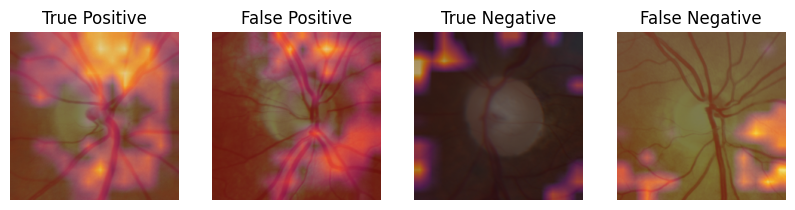

In [58]:
grayscale_cam = fundus_single_cam(input_tensor=torch.stack([proc_tp_img, 
                                                              proc_fp_img, 
                                                              proc_tn_img, 
                                                              proc_fn_img], dim = 0).to(device), 
                                    targets= [BinaryClassifierOutputTarget(1),
                                              BinaryClassifierOutputTarget(1),
                                              BinaryClassifierOutputTarget(0),
                                              BinaryClassifierOutputTarget(0)])
fig, ax = plt.subplots(1,4, figsize = (10,4))

ax[0].imshow(tp_img)
ax[0].imshow(grayscale_cam[0], cmap='inferno', alpha=0.5)
ax[0].set_title('True Positive')  # Set title for each subplot
ax[0].axis(False)

ax[1].imshow(fp_img)
ax[1].imshow(grayscale_cam[1], cmap='inferno', alpha=0.5)
ax[1].set_title('False Positive')  # Set title for each subplot
ax[1].axis(False)

ax[2].imshow(tn_img)
ax[2].imshow(grayscale_cam[2], cmap='inferno', alpha=0.5)
ax[2].set_title('True Negative')  # Set title for each subplot
ax[2].axis(False)

ax[3].imshow(fn_img)
ax[3].imshow(grayscale_cam[3], cmap='inferno', alpha=0.5)
ax[3].set_title('False Negative')  # Set title for each subplot
ax[3].axis(False)

plt.show()

# OCT single modality

In [36]:
single_mod_oct = torch.load("/tscc/nfs/home/vejoshi/oct_fundus_project/ret_found_exp/RETFound_MAE/experiments/best_oct/retFoundretFound_shape_224_dp_0.1_lr_0.0005_run_0.pt",
                                map_location = device)
oct_single_modal = build_model()
oct_single_modal.load_state_dict(single_mod_oct, strict=False)
oct_single_modal = oct_single_modal.to("cuda")
oct_single_modal.eval()
print("Loaded single modality OCT best model.")

Loaded single modality OCT best model.


# Extracting TP,TN,FP, FN images.
- 0 == Glaucoma
- 1 == Healthy

In [37]:
tp_img_path = "/tscc/nfs/home/vejoshi/oct_fundus_project/oct_fundus_dataset/oct_images/AL0798_A_29083_2.tif"
fp_img_path = "/tscc/nfs/home/vejoshi/oct_fundus_project/oct_fundus_dataset/oct_images/AL0376_A_26359_2.tif"
tn_img_path = "/tscc/nfs/home/vejoshi/oct_fundus_project/oct_fundus_dataset/oct_images/NY7749_N_41969_0.tif"
fn_img_path = "/tscc/nfs/home/vejoshi/oct_fundus_project/oct_fundus_dataset/oct_images/SD3227_S_1137_0.tif"

tp_img = PIL.Image.open(tp_img_path).convert('RGB').resize((224,224))
fp_img = PIL.Image.open(fp_img_path).convert('RGB').resize((224,224))
tn_img = PIL.Image.open(tn_img_path).convert('RGB').resize((224,224))
fn_img = PIL.Image.open(fn_img_path).convert('RGB').resize((224,224))

proc_tp_img = pre_proc_func(tp_img)
proc_fp_img = pre_proc_func(fp_img)
proc_tn_img = pre_proc_func(tn_img)
proc_fn_img = pre_proc_func(fn_img)

In [52]:
def reshape_transform(tensor, height=14, width=14):
    result = tensor[:, 1 :  , :].reshape(tensor.size(0),
        height, width, tensor.size(2))

    # Bring the channels to the first dimension,
    # like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result
    
oct_single_cam = GradCAMPlusPlus(model = oct_single_modal, 
                                 target_layers=[oct_single_modal.model.blocks[23].norm1], 
                                 reshape_transform = reshape_transform)

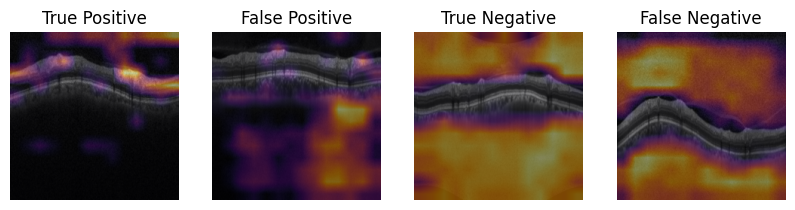

In [53]:
grayscale_cam = oct_single_cam(input_tensor=torch.stack([proc_tp_img, 
                                                              proc_fp_img, 
                                                              proc_tn_img, 
                                                              proc_fn_img], dim = 0).to(device), 
                                    targets= [BinaryClassifierOutputTarget(1),
                                              BinaryClassifierOutputTarget(1),
                                              BinaryClassifierOutputTarget(0),
                                              BinaryClassifierOutputTarget(0)])
fig, ax = plt.subplots(1,4, figsize = (10,4))

ax[0].imshow(tp_img)
ax[0].imshow(grayscale_cam[0], cmap='inferno', alpha=0.5)
ax[0].set_title('True Positive')  # Set title for each subplot
ax[0].axis(False)

ax[1].imshow(fp_img)
ax[1].imshow(grayscale_cam[1], cmap='inferno', alpha=0.5)
ax[1].set_title('False Positive')  # Set title for each subplot
ax[1].axis(False)

ax[2].imshow(tn_img)
ax[2].imshow(grayscale_cam[2], cmap='inferno', alpha=0.5)
ax[2].set_title('True Negative')  # Set title for each subplot
ax[2].axis(False)

ax[3].imshow(fn_img)
ax[3].imshow(grayscale_cam[3], cmap='inferno', alpha=0.5)
ax[3].set_title('False Negative')  # Set title for each subplot
ax[3].axis(False)

plt.show()

# MultiModal